# Setup

In [230]:
!pip install opendatasets -q

## Import Libraries

In [231]:
import pandas as pd
import numpy as np
import opendatasets as od
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Data Loading

In [232]:
od.download("https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database")

Skipping, found downloaded files in "./anime-recommendations-database" (use force=True to force download)


In [233]:
anime = pd.read_csv("/content/anime-recommendations-database/anime.csv")
rating = pd.read_csv("/content/anime-recommendations-database/rating.csv")

In [234]:
print("Total # of samples in anime dataframe: ", len(anime.anime_id.unique()))
print("Total # of samples in rating dataframe: ", len(rating))

Total # of samples in anime dataframe:  12294
Total # of samples in rating dataframe:  7813737


# Data Understanding
- dataset link: [click here!](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

## EDA - Variable Description

- anime.csv:
  - anime_id: myanimelist.net's unique id identifying an anime.
  - name: full name of anime.
  - genre: comma separated list of genres for this anime.
  - type: type of the anime. movie, TV, OVA, etc.
  - episodes: number of episodes. (1 if movie).
  - rating: average rating out of 10 for this anime.
  - members: number of community members that are in this anime's
"group".
- rating.csv
  - user_id: randomly generated user_id
  - anime_id:  the anime that this user has rated.
  - rating: rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

## DataFrame Anime

In [235]:
anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


As shown below, the genres in the 'genre' column are in comma-separated values format. This needs to be changed so that the machine can identify the genre of each anime.

The dataset is not clean, so it will be difficult to identify each genre available in the dataset. This will be explained in the **Data Preparation** section.

In [236]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [237]:
print(anime.shape)

(12294, 7)


## DataFrame Rating

In [238]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Rating dataframe has a lot of samples. This can be computationally expensive to train, to simplify this project the size will be reduced.

In [239]:
print(rating.shape)

(7813737, 3)


In [240]:
rating.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


In [241]:
print("Lowest rating: ", min(rating.rating))
print("Biggest rating: ", max(rating.rating))

Lowest rating:  -1
Biggest rating:  10


Total # of user:  73515
Total # of anime:  11200


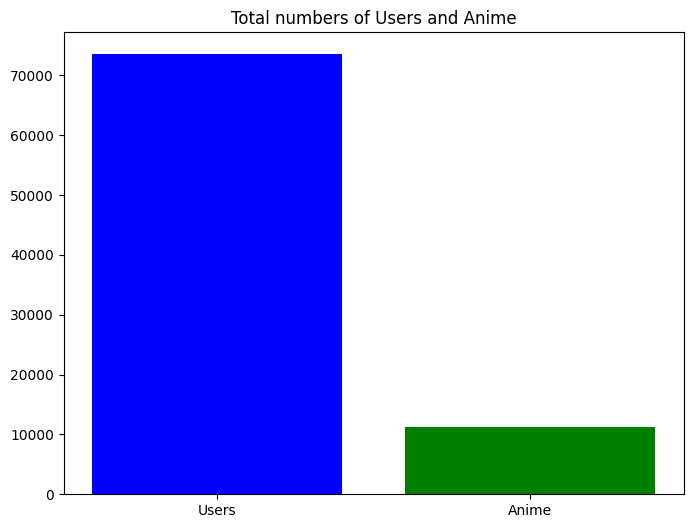

In [242]:
num_users = len(rating.user_id.unique())
num_anime = len(rating.anime_id.unique())

print("Total # of user: ", num_users)
print("Total # of anime: ", num_anime)

plt.figure(figsize=(8, 6))
plt.bar(['Users', 'Anime'], [num_users, num_anime], color=['blue', 'green'])
plt.title("Total numbers of Users and Anime")
plt.show()

# Data Preparation

## Anime Data Preparation

### Convert genre from each anime to list

In [243]:
anime['genre'] = anime['genre'].str.split(', ')

In [244]:
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",TV,64,9.26,793665
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.25,114262
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",TV,51,9.16,151266


### Handle missing values for anime dataframe

In [245]:
anime.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [246]:
anime_clean = anime.dropna()

In [247]:
anime_clean.isnull().sum()

anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

### Check unique genres

In [248]:
genre_flatten = [genre for sublist in anime_clean['genre'] for genre in sublist]

unique_genres = pd.Series(genre_flatten).unique()
print("Total # of genre: ", len(unique_genres))
print("List of all genre availabel: ", unique_genres)

Total # of genre:  43
List of all genre availabel:  ['Drama' 'Romance' 'School' 'Supernatural' 'Action' 'Adventure' 'Fantasy'
 'Magic' 'Military' 'Shounen' 'Comedy' 'Historical' 'Parody' 'Samurai'
 'Sci-Fi' 'Thriller' 'Sports' 'Super Power' 'Space' 'Slice of Life'
 'Mecha' 'Music' 'Mystery' 'Seinen' 'Martial Arts' 'Vampire' 'Shoujo'
 'Horror' 'Police' 'Psychological' 'Demons' 'Ecchi' 'Josei' 'Shounen Ai'
 'Game' 'Dementia' 'Harem' 'Cars' 'Kids' 'Shoujo Ai' 'Hentai' 'Yaoi'
 'Yuri']


### Drop unused columns

In [249]:
anime_new = anime_clean[['anime_id', 'name', 'genre']]
anime_new

,anime_id,name,genre
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ..."
3,9253,Steins;Gate,"[Sci-Fi, Thriller]"
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ..."
...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,[Hentai]
12290,5543,Under World,[Hentai]
12291,5621,Violence Gekiga David no Hoshi,[Hentai]
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,[Hentai]


### Drop rows with "R-rated" genres
- the "R-rated" genres i decided to drop is:
  - Yaoi
  - Yuri
  - Hentai
  - Shounen Ai
  - Shoujo Ai

In [250]:
r_rated_genres = ['Yaoi', 'Yuri', 'Hentai', 'Shounen Ai', 'Shoujo Ai']

mask = anime_new['genre'].apply(lambda x: any(genre in x for genre in r_rated_genres))

anime_final = anime_new[~mask]
anime_final

,anime_id,name,genre
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]"
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil..."
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ..."
3,9253,Steins;Gate,"[Sci-Fi, Thriller]"
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ..."
...,...,...,...
10891,11095,Zouressha ga Yatte Kita,[Adventure]
10892,7808,Zukkoke Knight: Don De La Mancha,"[Adventure, Comedy, Historical, Romance]"
10893,28543,Zukkoke Sannin-gumi no Hi Asobi Boushi Daisakusen,"[Drama, Kids]"
10894,18967,Zukkoke Sannin-gumi: Zukkoke Jikuu Bouken,"[Comedy, Historical, Sci-Fi]"


### Convert genre list to string
separates the genre list from each rows with space, and preventing the genre's with space from being separated

In [251]:
anime_final['genre_str'] = anime_final['genre'].apply(lambda x: ' '.join(g.replace(' ', '') for g in x))
anime_final

<ipython-input-251-c4e0b40f75e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anime_final['genre_str'] = anime_final['genre'].apply(lambda x: ' '.join(g.replace(' ', '') for g in x))


,anime_id,name,genre,genre_str
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Drama Romance School Supernatural
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic, Mil...",Action Adventure Drama Fantasy Magic Military ...
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samurai, ...",Action Comedy Historical Parody Samurai Sci-Fi...
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",Sci-Fi Thriller
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samurai, ...",Action Comedy Historical Parody Samurai Sci-Fi...
...,...,...,...,...
10891,11095,Zouressha ga Yatte Kita,[Adventure],Adventure
10892,7808,Zukkoke Knight: Don De La Mancha,"[Adventure, Comedy, Historical, Romance]",Adventure Comedy Historical Romance
10893,28543,Zukkoke Sannin-gumi no Hi Asobi Boushi Daisakusen,"[Drama, Kids]",Drama Kids
10894,18967,Zukkoke Sannin-gumi: Zukkoke Jikuu Bouken,"[Comedy, Historical, Sci-Fi]",Comedy Historical Sci-Fi


## Rating Data Preparation

### Reduce the size of rating dataframe

In [252]:
sample_size = int(len(rating) * 0.0005) # reduce the dataset into 0.05% of the original dataset size

rating = rating.sample(n=sample_size, random_state=69)

print("The size of rating dataset: ", len(rating))

The size of rating dataset:  3906


In [253]:
num_users = len(rating.user_id.unique())
num_anime = len(rating.anime_id.unique())

print("Total # of users after reduction: ", num_users)
print("Total # of anime after reduction: ", num_anime)

Total # of users after reduction:  3624
Total # of anime after reduction:  1769


### Encode the user id and anime id

In [254]:
user_ids = rating['user_id'].unique().tolist()
print("List user_id: ", user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print("Encoded user_id: ", user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print("Decoded user_id: ", user_encoded_to_user)

List user_id:  [34879, 21140, 41983, 31277, 6366, 51725, 57985, 41888, 61386, 41370, 66775, 26533, 54539, 21914, 59487, 57445, 35862, 10558, 61399, 17294, 68016, 14446, 47277, 69579, 53539, 3243, 51739, 70133, 3088, 13982, 52756, 5453, 16320, 56668, 9935, 44349, 48113, 45889, 58557, 11745, 8144, 36700, 24983, 32024, 43399, 35482, 44095, 127, 17623, 67708, 25351, 5598, 11474, 58774, 43543, 56099, 22070, 58903, 7935, 62832, 40617, 29581, 51494, 34915, 64825, 59921, 19334, 64372, 51369, 19631, 65723, 8129, 41253, 39185, 185, 56473, 48766, 34610, 27976, 58125, 38592, 18138, 54698, 35228, 6985, 60989, 59396, 44930, 50779, 50394, 22651, 58068, 53869, 2764, 58668, 53258, 55083, 4582, 58142, 68753, 51353, 58439, 10314, 20858, 40436, 5902, 42744, 70015, 64197, 57675, 20816, 19462, 34160, 3006, 70537, 25513, 17895, 42994, 63734, 49408, 54825, 40094, 47477, 31971, 20559, 18106, 43467, 23137, 2450, 6743, 29409, 71741, 41469, 37813, 21432, 10624, 65519, 12557, 33324, 29520, 40520, 71706, 47830, 262

In [255]:
anime_ids = rating['anime_id'].unique().tolist()
print("List anime_id: ", anime_ids)

anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
print("Encoded anime_id: ", anime_to_anime_encoded)

anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}
print("Decoded anime_id: ", anime_encoded_to_anime)

List anime_id:  [11577, 20021, 11701, 540, 9332, 10568, 889, 11785, 572, 519, 1133, 7785, 1195, 721, 3457, 5204, 21327, 849, 6637, 477, 523, 45, 4181, 14075, 5279, 15605, 5525, 1535, 18245, 10396, 1172, 11979, 4898, 21659, 1564, 17205, 3559, 71, 1202, 16918, 13659, 24991, 394, 4752, 15037, 8407, 22125, 896, 14813, 8457, 16934, 29095, 936, 11135, 18507, 23405, 26243, 7647, 877, 2251, 13055, 28805, 64, 10321, 9513, 7465, 25241, 30437, 13601, 1807, 12711, 418, 861, 2969, 1686, 24765, 1156, 2001, 1555, 11757, 31636, 12015, 1182, 1597, 1349, 1840, 16397, 1347, 13367, 121, 23289, 2104, 2605, 31414, 900, 93, 1594, 3166, 934, 2597, 850, 2904, 9367, 120, 1482, 21435, 8074, 22297, 352, 20, 16049, 23755, 9041, 228, 29786, 2827, 15225, 4654, 2476, 357, 23283, 4214, 10793, 6347, 249, 2787, 30276, 11759, 15689, 405, 15417, 14653, 11843, 762, 8861, 24695, 2889, 11763, 8516, 16067, 1570, 20815, 1121, 738, 548, 29854, 9656, 4224, 57, 6645, 710, 565, 3785, 1818, 14353, 1766, 8246, 18679, 9756, 5680, 172

In [256]:
# Map the encoded user_id and anime_id into new columns
rating['user'] = rating['user_id'].map(user_to_user_encoded)
rating['anime'] = rating['anime_id'].map(anime_to_anime_encoded)

### Change -1 rating to 0

In [257]:
rating['rating'] = rating['rating'].replace(-1, 0)

min_rating = min(rating['rating'])
max_rating = max(rating['rating'])

print("Lowest rating: ", min_rating)
print("Highest rating: ", max_rating)

# change to float
rating['rating'] = rating['rating'].values.astype(np.float32)

Lowest rating:  0
Highest rating:  10


### Split into train and validation

before splitting, randomize the data first

In [258]:
rating = rating.sample(frac=1, random_state=69)
rating

,user_id,anime_id,rating,user,anime
5439589,51353,934,9.0,100,98
4814901,45935,8074,0.0,712,106
43715,462,29093,8.0,583,498
4550520,43393,20045,9.0,1214,858
2099982,20341,665,0.0,3106,1617
...,...,...,...,...,...
2419370,23088,3031,8.0,438,396
6649679,61353,834,9.0,1587,346
2672590,25227,6164,9.0,2540,1427
1486969,14294,16894,8.0,2485,1297


In [259]:
x = rating[['user', 'anime']].values

# Normalization using min max scaler
y = rating['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

train_indices = int(0.8 * rating.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print("Training data: ", x)
print("Validation data: ", y)

Training data:  [[ 100   98]
 [ 712  106]
 [ 583  498]
 ...
 [2540 1427]
 [2485 1297]
 [2935  507]]
Validation data:  [0.9 0.  0.8 ... 0.9 0.8 0.8]


# Model Development with Content-Based Filtering

In [260]:
data = anime_final
data.sample(5)

,anime_id,name,genre,genre_str
2901,1225,3x3 Eyes Seima Densetsu,"[Action, Adventure, Demons, Fantasy, Horror, R...",Action Adventure Demons Fantasy Horror Romance
10403,15111,Spy Penguin,[Kids],Kids
5584,23985,Futari Ecchi (2014),"[Comedy, Ecchi, Romance, Seinen, Slice of Life]",Comedy Ecchi Romance Seinen SliceofLife
2289,12651,Danball Senki W,"[Action, Kids, Mecha]",Action Kids Mecha
2224,2671,Doraemon Movie 03: Nobita no Daimakyou,[Adventure],Adventure


## TF-IDF Vectorizer

In [261]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer()

tfv.fit(data['genre_str'])

tfv.get_feature_names_out()

array(['action', 'adventure', 'cars', 'comedy', 'dementia', 'demons',
       'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem', 'historical',
       'horror', 'josei', 'kids', 'magic', 'martialarts', 'mecha',
       'military', 'music', 'mystery', 'parody', 'police',
       'psychological', 'romance', 'samurai', 'school', 'sci', 'seinen',
       'shoujo', 'shounen', 'sliceoflife', 'space', 'sports',
       'supernatural', 'superpower', 'thriller', 'vampire'], dtype=object)

In [262]:
tfidf_matrix = tfv.fit_transform(data['genre_str'])

tfidf_matrix.shape

(10733, 39)

## View DataFrame

In [263]:
# Create dataframe to view tfidf_matrix
# Column is filled with genres
# Row is filled with anime names

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfv.get_feature_names_out(),
    index=data['name']
).sample(10, axis=1).sample(5, axis=0)

,game,music,school,sports,sliceoflife,comedy,ecchi,horror,shounen,historical
name,,,,,,,,,,
Bulg-eunmae,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Choboraunyopomi Gekijou Ai Mai Mii,0.0,0.0,0.0,0.0,0.862944,0.505299,0.0,0.0,0.0,0.0
Armageddon,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Doubutsu Sumo Taikai,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
The World of Golden Eggs,0.0,0.0,0.0,0.0,0.000000,0.398915,0.0,0.0,0.0,0.0


## Cosine Similarity

In [264]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.14596888, 0.        , ..., 0.29799153, 0.        ,
        0.        ],
       [0.14596888, 1.        , 0.17688183, ..., 0.23069816, 0.        ,
        0.        ],
       [0.        , 0.17688183, 1.        , ..., 0.        , 0.58198958,
        0.19632063],
       ...,
       [0.29799153, 0.23069816, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.58198958, ..., 0.        , 1.        ,
        0.3373267 ],
       [0.        , 0.        , 0.19632063, ..., 0.        , 0.3373267 ,
        1.        ]])

## Cosine Similarity DataFrame

In [265]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['name'], columns=data['name'])
print("Shape: ", cosine_sim_df.shape)

cosine_sim_df.sample(10, axis=1).sample(10, axis=0)

Shape:  (10733, 10733)


name,Chocolate Underground: Bokura no Chocolate Sensou,Bleach Movie 2: The DiamondDust Rebellion - Mou Hitotsu no Hyourinmaru,Long Riders Recap,Hi no Tori: Uchuu-hen,Hyakka Ryouran: Samurai Girls Specials,Ie Naki Ko Remi,Sora no Momotarou,Aquarian Age: Saga II - Don&#039;t Forget Me...,Tenchi Muyou! Ryououki,Zeonic Toyota Special Movie
name,,,,,,,,,,
WWW.Working!!,0.00000,0.000000,0.602638,0.000000,0.0,0.453010,0.178876,0.000000,0.133349,0.0
Persona 3 the Movie Meets “Walkman”,0.00000,0.000000,0.000000,0.511575,0.0,0.448155,0.000000,0.494672,0.000000,0.0
Psychoarmor Govarian,0.00000,0.141801,0.000000,0.382101,0.0,0.000000,0.000000,0.594591,0.400257,0.0
Video Ehonkan Sekai Meisaku Douwa,0.25777,0.327976,0.058028,0.400946,0.0,0.324578,0.190893,0.000000,0.525580,0.0
White Tree,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Behind a Smile,0.00000,0.154986,0.000000,0.000000,0.0,0.000000,0.000000,0.158627,0.123378,0.0
Bokura Machi Bouzu!,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
Ring of Gundam,0.00000,0.000000,0.000000,0.399378,0.0,0.000000,0.000000,0.000000,0.696329,0.0
Shashinki,0.00000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0


## Getting top-N Recommendations

In [266]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=data[['name', 'genre']], k=5):
  """
  Rekomendasi anime berdasarkan kemiripan di dataframe

  Parameter:
  nama_anime: tipe data string (str)
  similarity_data: tipe data pd.DataFrame (object), kesamaan dataframe dengan anime sebagai index dan kolom
  items: tipe data pd.DataFrame (object), mengandung kedua nama dan fitur lainnya untuk mendefinisikan kemiripan
  k: tipe data integer (int), jumlah rekomendasi yang ingin didapatkan
  """

  index = similarity_data.loc[:, nama_anime].to_numpy().argpartition(
      range(-1, -k, -1)
  )

  closest = similarity_data.columns[index[-1:-(k+2):-1]]

  closest = closest.drop(nama_anime, errors='ignore')

  pd.set_option('display.max_columns', None)
  return pd.DataFrame(closest).merge(items).head(k)

In [273]:
anime_input = input("Input anime name: ")
data[data['name'].str.contains(anime_input, case=False)]

Input anime name: monogatari


,anime_id,name,genre,genre_str
26,17074,Monogatari Series: Second Season,"[Comedy, Mystery, Romance, Supernatural, Vampire]",Comedy Mystery Romance Supernatural Vampire
37,31757,Kizumonogatari II: Nekketsu-hen,"[Action, Mystery, Supernatural, Vampire]",Action Mystery Supernatural Vampire
102,11981,Mahou Shoujo Madoka★Magica Movie 3: Hangyaku n...,"[Drama, Magic, Psychological, Thriller]",Drama Magic Psychological Thriller
107,11979,Mahou Shoujo Madoka★Magica Movie 2: Eien no Mo...,"[Drama, Magic, Psychological, Thriller]",Drama Magic Psychological Thriller
129,9260,Kizumonogatari I: Tekketsu-hen,"[Mystery, Supernatural, Vampire]",Mystery Supernatural Vampire
...,...,...,...,...
10602,25079,Trapp Ikka Monogatari Specials,"[Drama, Historical, Music, Romance]",Drama Historical Music Romance
10621,32646,Tsuzuki wo Kangaeru Monogatari,[Drama],Drama
10704,23741,Wakakusa Monogatari: Nan to Jo-sensei Specials,"[Drama, Historical, School, Slice of Life]",Drama Historical School SliceofLife
10778,24603,Xiongmao Monogatari TaoTao,"[Comedy, Fantasy, Kids]",Comedy Fantasy Kids


In [268]:
# Get top-N Recommendations based from anime input list
anime_recommendations('Kizumonogatari I: Tekketsu-hen', k=10)

,name,genre
0,Vampire Holmes,"[Comedy, Mystery, Supernatural, Vampire]"
1,Kizumonogatari II: Nekketsu-hen,"[Action, Mystery, Supernatural, Vampire]"
2,Bakemonogatari,"[Mystery, Romance, Supernatural, Vampire]"
3,Monogatari Series: Second Season,"[Comedy, Mystery, Romance, Supernatural, Vampire]"
4,Shiki Specials,"[Horror, Mystery, Supernatural, Vampire]"
5,Vampire Knight,"[Drama, Mystery, Romance, Shoujo, Supernatural..."
6,Vampire Knight Guilty,"[Drama, Mystery, Romance, Shoujo, Supernatural..."
7,Shiki,"[Mystery, Supernatural, Thriller, Vampire]"
8,Trinity Blood,"[Action, Supernatural, Vampire]"
9,Dance in the Vampire Bund Recap,"[Action, Supernatural, Vampire]"


# Model Development with Collaborative Filtering

## Create a RecommenderNet Class

In [269]:
class RecommenderNet(tf.keras.Model):

  # Function initialization
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:, 0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)

    x = dot_user_anime + user_bias + anime_bias

    return tf.nn.sigmoid(x)

## Model Compile

In [270]:
model = RecommenderNet(num_users, num_anime, 100)

model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

## Model Training

In [271]:
modelku = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 48,
    epochs=100,
    validation_data=(x_val, y_val)
)

Epoch 1/100
66/66 [==============================] - 3s 17ms/step - loss: 0.6940 - mean_absolute_error: 0.3300 - val_loss: 0.6940 - val_mean_absolute_error: 0.3384
Epoch 2/100
66/66 [==============================] - 1s 10ms/step - loss: 0.6965 - mean_absolute_error: 0.2483 - val_loss: 0.6935 - val_mean_absolute_error: 0.3382
Epoch 3/100
66/66 [==============================] - 1s 9ms/step - loss: 0.7010 - mean_absolute_error: 0.3391 - val_loss: 0.6920 - val_mean_absolute_error: 0.3368
Epoch 4/100
66/66 [==============================] - 1s 9ms/step - loss: 0.6924 - mean_absolute_error: 0.2457 - val_loss: 0.6915 - val_mean_absolute_error: 0.3366
Epoch 5/100
66/66 [==============================] - 1s 9ms/step - loss: 0.6687 - mean_absolute_error: 0.3077 - val_loss: 0.6904 - val_mean_absolute_error: 0.3357
Epoch 6/100
66/66 [==============================] - 1s 8ms/step - loss: 0.6556 - mean_absolute_error: 0.2436 - val_loss: 0.6901 - val_mean_absolute_error: 0.3355
Epoch 7/100
66/66 [=

## Metrics Visualization

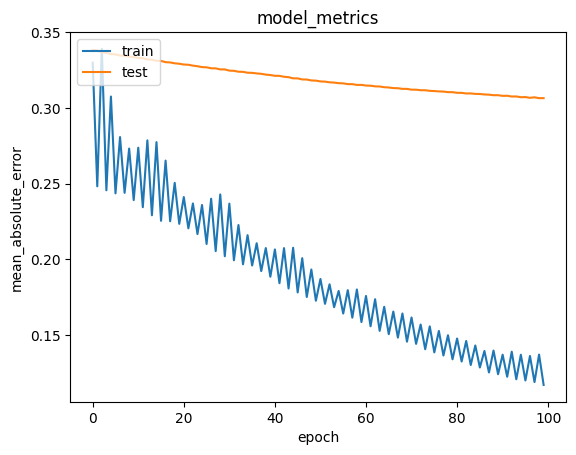

In [272]:
plt.plot(modelku.history['mean_absolute_error'])
plt.plot(modelku.history['val_mean_absolute_error'])
plt.title('model_metrics')
plt.ylabel('mean_absolute_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Getting top-N Recommendations

In [313]:
anime_df = anime_final

# get sample user
user_id = rating.user_id.sample(1).iloc[0]
anime_watched_by_user = rating[rating.user_id == user_id]

anime_not_watched = anime_df[~anime_df['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id']
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

In [315]:
ratings = model.predict(user_anime_array).flatten()
print(ratings)

top_ratings_indices = ratings.argsort()[-10:][::1]
print(top_ratings_indices)
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]
print(recommended_anime_ids)

print(f"Showing recommendations for user: {user_id}")
print("===" * 9)
print("Anime with high ratings from user")
print("----" * 8)

top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

anime_df_rows = anime_df[anime_df['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
  print(row.name, ":", row.genre)

print('----' * 8)
print("Top 10 anime recommendations")
print('----' * 8)

recommended_anime = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)]
print(anime_df[anime_df['anime_id'].isin([774,895,19])])
for row in recommended_anime.itertuples():
  print(row.name, ':', row.genre)

53/53 [==============================] - 0s 3ms/step
[0.7539885  0.43538556 0.7150704  ... 0.32923043 0.35586628 0.63284093]
[ 773  895  441  582 1548   18 1123 1287 1248  787]
[18507, 2759, 934, 9656, 7059, 45, 4181, 5341, 5114, 2167]
Showing recommendations for user: 34695
Anime with high ratings from user
--------------------------------
Eyeshield 21 : ['Action', 'Comedy', 'Shounen', 'Sports']
--------------------------------
Top 10 anime recommendations
--------------------------------
      anime_id                                               name  \
38          19                                            Monster   
3756       895  Dragon Ball Z Movie 02: Kono Yo de Ichiban Tsu...   

                                                  genre  \
38    [Drama, Horror, Mystery, Police, Psychological...   
3756      [Adventure, Comedy, Fantasy, Sci-Fi, Shounen]   

                                              genre_str  
38    Drama Horror Mystery Police Psychological Sein...  
375